In [1]:
from itertools import product
import multiprocessing

import pandas as pd
import seaborn as sns
import matplotlib as plt
import scipy.sparse as sp
import numpy as np

from fairpair import *

In [2]:
from accuracy_workers import *

## Export Graphs

In [4]:
G = FairPairGraph()
G.generate_groups(400, 200) # same size groups
G.assign_skills(loc=0, scale=0.86142674) # general skill distribution
G.assign_bias(nodes=G.minority_nodes, loc=-1.43574282, scale=0.43071336) # add bias to unprivileged group

In [8]:
sampler = RandomSampling(G, warn=False)
ranker = RankRecovery(G)
path = './data/GNNRank_networks/'

for j in range(101):
    sampler.apply(iter=10, k=1)
    if nx.is_strongly_connected(G): # only apply ranking recovery if strongly connected
        adj = nx.linalg.graphmatrix.adjacency_matrix(G, weight='weight') # returns a sparse matrix
        nodes = np.array(G.nodes)
        sp.save_npz(f'{path}random_iter{j*10}_adj', adj)
        np.save(f'{path}random_iter{j*10}_node_list', nodes)

## Read Results

In [3]:
path = './data/GNNRank_results/'
ranking = np.load(f'{path}DIGRACinnerproduct_pred0.npy')

In [ ]:
ranks = []
j = 500
for node, data in G.majority.nodes(data=True):
    ranks.append((j, data['skill'], 0, data['score'], ranking[node], 'Privileged'))
for node, data in G.minority.nodes(data=True):
    ranks.append((j, data['skill'], data['bias'], data['score'], ranking[node], 'Unprivileged'))
ranks = pd.DataFrame(ranks, columns=['iteration', 'skill score', 'bias', 'average perceived score', 'rank', 'group'])

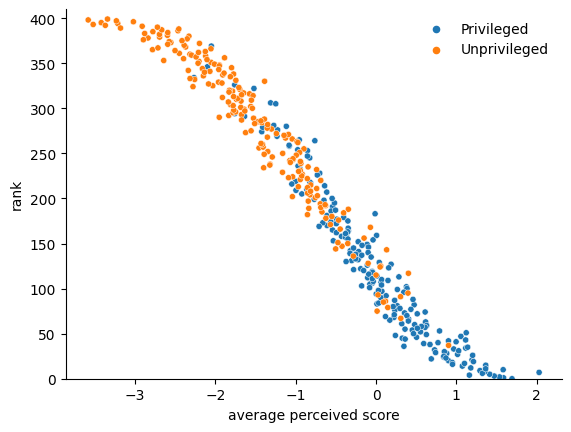

In [14]:
data = ranks
data['rank'] = [rank for rank in scores_to_rank({node:score for node, score in enumerate(list(data['rank']))}, invert=True).values()]
ax = sns.scatterplot(data, x='average perceived score', y='rank', hue='group', hue_order=['Privileged', 'Unprivileged'], size='group', sizes=(20,20))
ax.legend(title=None, frameon=False, loc='upper right')
ax.set(ylim=(0,410)) # xlim=(-10, 10)
sns.despine()

## Integrated Evaluation

In [4]:
import torch

import sys
sys.path.append('../GNNRank/') # also add the path to Pylance in VSCode settings: python.analysis.extraPaths

from src.param_parser import ArgsNamespace # just import the class, not the parser
from src.Trainer import Trainer

In [9]:
# Instead of parsing, set all arguments directly
# Carefully check if the settings are actually possible!
args = ArgsNamespace(AllTrain=True, ERO_style='uniform', F=70, Fiedler_layer_num=5, K=20, N=350, SavePred=False, all_methods=['DIGRAC', 'ib'],
                     alpha=1.0, baseline='syncRank', be_silent=False, cuda=True, data_path='/home/jovyan/GNNRank/src/../data/', dataset='fairPair_test/',
                     debug=False, device=torch.device(type='cuda'), dropout=0.5, early_stopping=200, epochs=1000, eta=0.1, fill_val=0.5, hidden=8, hop=2,
                     load_only=False, log_root='/home/jovyan/GNNRank/src/../logs/', lr=0.01, no_cuda=False, num_trials=1, optimizer='Adam', p=0.05,
                     pretrain_epochs=50, pretrain_with='dist', regenerate_data=True, season=1990, seed=31, seeds=[10], sigma=1.0, tau=0.5, test_ratio=1,
                     train_ratio=1, train_with='proximal_baseline', trainable_alpha=False, upset_margin=0.01, upset_margin_coeff=0, upset_ratio_coeff=1.0, weight_decay=0.0005)
torch.manual_seed(args.seed)

In [6]:
G = FairPairGraph()
G.generate_groups(400, 200) # same size groups
G.assign_skills(loc=0, scale=0.86142674) # general skill distribution
G.assign_bias(nodes=G.minority_nodes, loc=-1.43574282, scale=0.43071336) # add bias to unprivileged group

In [7]:
sampler = RandomSampling(G, warn=False)
sampler.apply(iter=40, k=1)
print('G is strongly connected.' if nx.is_strongly_connected(G) else 'G is NOT strongly connected!')
print(f'G has {G.number_of_nodes()} nodes and {len(G.edges)} edges.')

G is strongly connected.
G has 400 nodes and 3152 edges.


In [10]:
adj = nx.linalg.graphmatrix.adjacency_matrix(G, weight='weight') # returns a sparse matrix
trainer = Trainer(args, random_seed=10, save_name_base='test', adj=adj) # initialize with the given adjacency matrix

Generating new data or new data splits!
loaded test_mask: None


In [11]:
save_path_best, save_path_latest = trainer.train(model_name='ib')

  0%|          | 0/1000 [00:00<?, ?epochs/s]

Early stopped after 200 epochs without improvement.


In [ ]:
### Test modifying the network to investigate effects on generalizability

## Adding comparisons
#sampler.apply(iter=1000, k=1)
#print(f'G has {G.number_of_nodes()} nodes and {len(G.edges)} edges.')

## Dropping edges
#rng = np.random.default_rng()
#to_remove = rng.choice(G.edges, size=1000, replace=False)
#G.remove_edges_from(to_remove)
#print(f'Removed 40000 edges. G has now {G.number_of_nodes()} nodes and {len(G.edges)} edges.')

In [19]:
#adj = nx.linalg.graphmatrix.adjacency_matrix(G, weight='weight') # returns a sparse matrix
# We load A while initializing a new Trainer instance
score, pred_label = trainer.predict_nn(model_name='ib', model_path=save_path_best, A=None, GNN_variant='proximal_baseline')
ranking = {key: 1-score[0] for key, score in enumerate(score.cpu().detach().numpy())}
ranking

{0: 0.5144670009613037,
 1: 0.5345504581928253,
 2: 0.5061275362968445,
 3: 0.5409384965896606,
 4: 0.49386847019195557,
 5: 0.5257960855960846,
 6: 0.46082282066345215,
 7: 0.5344527661800385,
 8: 0.517162412405014,
 9: 0.5285908281803131,
 10: 0.48855143785476685,
 11: 0.538844883441925,
 12: 0.4828869700431824,
 13: 0.5032058358192444,
 14: 0.5074435770511627,
 15: 0.525470644235611,
 16: 0.5505736768245697,
 17: 0.513301432132721,
 18: 0.47091519832611084,
 19: 0.480710506439209,
 20: 0.48365455865859985,
 21: 0.540238618850708,
 22: 0.5278501808643341,
 23: 0.49943113327026367,
 24: 0.4806326627731323,
 25: 0.5133569240570068,
 26: 0.5107673108577728,
 27: 0.4980122447013855,
 28: 0.5245898365974426,
 29: 0.4920641779899597,
 30: 0.5237485766410828,
 31: 0.48397594690322876,
 32: 0.5131720900535583,
 33: 0.482882022857666,
 34: 0.5474376082420349,
 35: 0.5111722648143768,
 36: 0.5138053894042969,
 37: 0.5097498893737793,
 38: 0.49211448431015015,
 39: 0.4763866066932678,
 40: 0.52

In [16]:
weighted_tau(G, ranking, score_attr='score')

0.26336010686934586

In [17]:
ranker = RankRecovery(G)
ranking2, other_nodes = ranker.apply()
weighted_tau(G, ranking2, score_attr='score')

0.2717231190150487

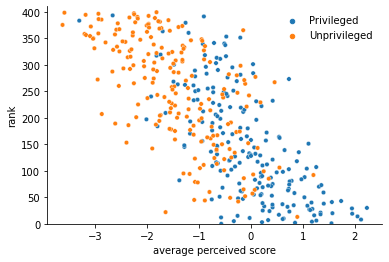

In [18]:
ranks = []
j = 500

for node, data in G.nodes(data=True):
    ranks.append((j, data['skill'], 0, data['score'], ranking[node], 'Unprivileged' if data['minority'] else 'Privileged'))
ranks = pd.DataFrame(ranks, columns=['iteration', 'skill score', 'bias', 'average perceived score', 'rank', 'group'])
data = ranks
data['rank'] = [rank for rank in scores_to_rank({node:score for node, score in enumerate(list(data['rank']))}, invert=True).values()]
ax = sns.scatterplot(data, x='average perceived score', y='rank', hue='group', hue_order=['Privileged', 'Unprivileged'], size='group', sizes=(20,20))
ax.legend(title=None, frameon=False, loc='upper right')
ax.set(ylim=(0,410)) # xlim=(-10, 10)
sns.despine()

## Parallel GNNRank

In [ ]:
if __name__ == '__main__':
    multiprocessing.set_start_method('spawn')
    pool = multiprocessing.Pool(processes=10) # limit the num of processes in order to not overflow the GPU memory
    accuracy = pool.map(get_GNNRank_accuracy, range(10))
    accuracy = [result for pool in accuracy for result in pool]
    accuracy = pd.DataFrame(accuracy, columns=['trial', 'iteration', 'Weighted Kemeny distance', 'group'])

In [4]:
accuracy.to_csv('./data/GNNRank_results/skill_accuracy_no_bias.csv', index=False)

In [3]:
accuracy = pd.read_csv('./data/GNNRank_results/skill_accuracy.csv')

In [4]:
tasks = list(product(range(10), [davidScore, rankCentrality]))

if __name__ == '__main__':
    pool = multiprocessing.Pool()
    accuracy2 = pool.starmap(get_method_accuracy, tasks)
    accuracy2 = [result for pool in accuracy2 for result in pool]
    accuracy2 = pd.DataFrame(accuracy2, columns=['trial', 'iteration', 'Weighted Kemeny distance', 'group', 'method'])

In [5]:
accuracy['method'] = 'GNNRank'
data = pd.concat([accuracy, accuracy2])

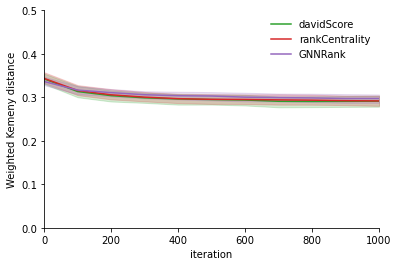

In [6]:
palette = sns.color_palette()
palette[0] = palette[2]
palette[1] = palette[3]
palette[2] = palette[4]
with sns.color_palette(palette):
    ax = sns.lineplot(data, x='iteration', y='Weighted Kemeny distance', hue='method', hue_order=['davidScore', 'rankCentrality', 'GNNRank'])
ax.legend(title=None, frameon=False, prop={'size': 10})
ax.set(ylim=(0,0.5), xlim=(0,1000))
sns.despine()
ax.figure.savefig('accuracy_y5.png',dpi=600)

## Generalizability

In [ ]:
tasks = list(product(range(10), [100]))

if __name__ == '__main__':
    try: multiprocessing.set_start_method('spawn') # if it wasn't alrady set, make sure we use the `spawn` method.
    except RuntimeError: pass
    pool = multiprocessing.Pool(processes=10) # limit the num of processes in order to not overflow the GPU memory
    accuracy = pool.starmap(get_GNNRank_generalizability, tasks)
    accuracy = [result for pool in accuracy for result in pool]
    accuracy = pd.DataFrame(accuracy, columns=['trial', 'iteration', 'Weighted Kemeny distance', 'Model trained after'])

In [4]:
accuracy.to_csv('./data/GNNRank_results/generalizability100_no_bias.csv', index=False)

In [3]:
accuracy1 = pd.read_csv('./data/GNNRank_results/generalizability_no_bias.csv') # includes data for 50, 500, 1000
accuracy2 = pd.read_csv('./data/GNNRank_results/generalizability100_no_bias.csv') # includes data for 100
accuracy3 = pd.read_csv('./data/GNNRank_results/skill_accuracy_no_bias.csv') # includes data for baseline (trained after each step)
accuracy1['Model trained after'] = accuracy1['Model trained after'].map(str) + ' iterations'
accuracy1.iteration += 10
accuracy2['Model trained after'] = accuracy2['Model trained after'].map(str) + ' iterations'
accuracy2.iteration += 10
accuracy3['Model trained after'] = 'each step'
accuracy3.iteration += 100 # offset is larger because steps are coarser
data = pd.concat([accuracy1, accuracy2, accuracy3])

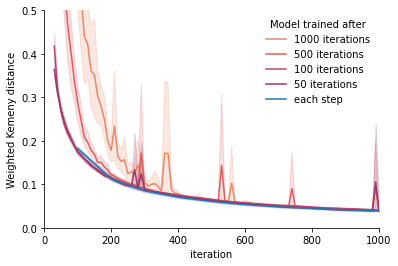

In [18]:
std_palette = sns.color_palette()
palette = sns.color_palette('flare', 5)
palette[4] = std_palette[0]
ax = sns.lineplot(data, x='iteration', y='Weighted Kemeny distance', hue='Model trained after',
                  hue_order=['1000 iterations', '500 iterations', '100 iterations', '50 iterations', 'each step'], palette=palette)
ax.legend(title='Model trained after', frameon=False, prop={'size': 10})
ax.set(ylim=(0,0.5), xlim=(0,1000))
sns.despine()
ax.figure.savefig('generalizability_y5.png',dpi=600)

In [10]:
data.loc[(data.iteration>300) & (data['Weighted Kemeny distance']>0.3)] #weird spikes

,trial,iteration,Weighted Kemeny distance,Model trained after,group
1379,4,990,0.563490,500 iterations,NaN
1576,5,990,0.702303,50 iterations,NaN
1629,5,530,0.880669,500 iterations,NaN
1650,5,740,0.469575,500 iterations,NaN
2027,6,560,0.489774,1000 iterations,NaN
2302,7,360,0.902188,1000 iterations,NaN
2600,8,370,0.800016,1000 iterations,NaN


## Full Accuracy Evaluation Using Generalizing Models

In [ ]:
tasks = list(product(range(10), [RandomSampling, OversampleMinority, RankSampling], [False, True])) # trial, samplingMethod, apply_bias

if __name__ == '__main__':
    try: multiprocessing.set_start_method('spawn') # if it wasn't alrady set, make sure we use the `spawn` method.
    except RuntimeError: pass
    pool = multiprocessing.Pool(processes=10) # limit the num of processes in order to not overflow the GPU memory
    accuracy = pool.starmap(get_GNNRank_weightedTau, tasks)
    accuracy = [result for pool in accuracy for result in pool]
    accuracy = pd.DataFrame(accuracy, columns=['trial', 'iteration', 'value', 'bias_applied', 'sampling method', 'metric', 'group'])

In [4]:
accuracy.to_csv('./data/GNNRank_results/samplingExperiments_full.csv', index=False)

In [5]:
accuracy

,trial,iteration,value,bias_applied,sampling method,metric,group
0,0,30,0.368603,False,RandomSampling,tau,Overall
1,0,30,0.377006,False,RandomSampling,tau,Privileged
2,0,30,0.362220,False,RandomSampling,tau,Unprivileged
3,0,30,0.388764,False,RandomSampling,tau,Privileged within-group
4,0,30,0.371395,False,RandomSampling,tau,Between groups
...,...,...,...,...,...,...,...
46323,9,1000,0.034176,True,RankSampling,tau,Privileged within-group
46324,9,1000,0.421675,True,RankSampling,tau,Between groups
46325,9,1000,0.162662,True,RankSampling,tau,Unprivileged within-group
46326,9,1000,0.170238,True,RankSampling,exposure,Privileged


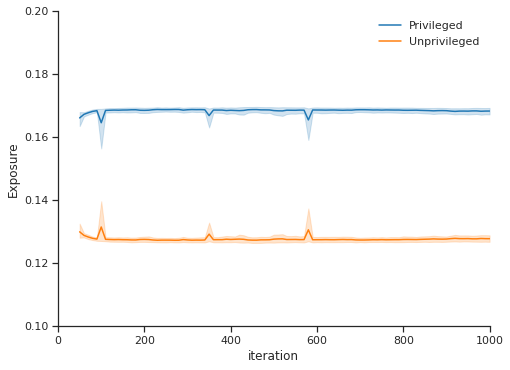

In [64]:
df = accuracy.loc[(accuracy['sampling method'] == 'OversampleMinority') & (accuracy.metric == 'exposure') & (accuracy.bias_applied == True)].copy()

# remove outliers from bad generalization
for group in df.group.unique():
    df.loc[df.group == group, 'rolling'] = df.loc[df.group == group, 'value'].rolling(5, min_periods=1).mean()
df.loc[df.value > df['rolling'] + 0.1, 'value'] = None

df['Exposure'] = df.value

palette = sns.color_palette('tab10')
palette[2] = palette[7]
sns.set(rc={'figure.figsize':(4/3*5.8,5.8)})
sns.set_style('ticks')
with sns.color_palette(palette):
    ax = sns.lineplot(df, x='iteration', y='Exposure', hue='group', hue_order=['Privileged', 'Unprivileged'])
    #ax = sns.lineplot(df, x='iteration', y='Exposure', hue='group', hue_order=['Privileged within-group', 'Unprivileged within-group', 'Between groups'])
ax.legend(title=None, frameon=False) #.remove()
ax.set(ylim=(0.1,0.2), xlim=(0,1000))
sns.despine()
plt.savefig('plots/exposure_oversample75_10trials.png', dpi=150)